<a href="https://colab.research.google.com/github/Maheshdudala/Ai_Stylist__Infosys_Internship_Oct2024_Team2/blob/Prashanna/RecSys_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow tensorflow-recommenders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.6 MB/s eta 0:00:00


In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv('Final Fashion Dataset.csv')
df = df.head(1000)


columns = ['user_id', 'id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'ratings', 'Price (USD)']
df = df[columns]

categorical_features = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour']
numerical_features = ['Price (USD)', 'ratings']


for feature in categorical_features:
    print(f"Unique values in {feature}: {df[feature].unique()}")

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])


final_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
final_data[numerical_features] = df[numerical_features].values


X = final_data.values
y = np.zeros(X.shape[0])

# Set up embeddings based on unique counts
gender_unique = df['gender'].nunique()
master_category_unique = df['masterCategory'].nunique()
sub_category_unique = df['subCategory'].nunique()
article_type_unique = df['articleType'].nunique()
base_colour_unique = df['baseColour'].nunique()

Unique values in gender: ['Women' 'Men' 'Unisex' 'Boys' 'Girls']
Unique values in masterCategory: ['Apparel' 'Accessories' 'Footwear']
Unique values in subCategory: ['Bottomwear' 'Topwear' 'Bags' 'Watches' 'Shoes' 'Flip Flops' 'Jewellery'
 'Eyewear' 'Belts' 'Saree' 'Loungewear and Nightwear' 'Wallets' 'Socks']
Unique values in articleType: ['Skirts' 'Kurtas' 'Handbags' 'Tshirts' 'Watches' 'Formal Shoes'
 'Flip Flops' 'Heels' 'Leggings' 'Backpacks' 'Earrings' 'Clutches'
 'Shirts' 'Casual Shoes' 'Dupatta' 'Jeans' 'Tops' 'Ring' 'Flats'
 'Suspenders' 'Sports Shoes' 'Sunglasses' 'Shorts' 'Belts' 'Sarees'
 'Nightdress' 'Jackets' 'Trousers' 'Messenger Bag' 'Track Pants' 'Kurtis'
 'Capris' 'Nehru Jackets' 'Sweatshirts' 'Wallets' 'Socks'
 'Necklace and Chains' 'Stockings' 'Waist Pouch' 'Patiala' 'Tunics'
 'Booties' 'Lounge Pants' 'Sweaters' 'Pendant' 'Duffel Bag' 'Tracksuits'
 'Baby Dolls' 'Bath Robe' 'Laptop Bag' 'Night suits' 'Tights']
Unique values in baseColour: ['Black' 'Grey' 'Blue' 'Pink

In [82]:
df.head(5)

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,ratings,Price (USD)
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,5,46
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,4,29
2,13278,14881,Women,Accessories,Bags,Handbags,Black,3,39
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,5,39
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,4,33


In [80]:
class FashionRecommender(tf.keras.Model):
    def __init__(self):
        super(FashionRecommender, self).__init__()

        # Define embedding layers for categorical features
        self.gender_embedding = tf.keras.layers.Embedding(input_dim=gender_unique, output_dim=8)
        self.master_category_embedding = tf.keras.layers.Embedding(input_dim=master_category_unique, output_dim=8)
        self.sub_category_embedding = tf.keras.layers.Embedding(input_dim=sub_category_unique, output_dim=8)
        self.article_type_embedding = tf.keras.layers.Embedding(input_dim=article_type_unique, output_dim=8)
        self.base_colour_embedding = tf.keras.layers.Embedding(input_dim=base_colour_unique, output_dim=8)

        # Dense layers for numerical features
        self.price_dense = tf.keras.layers.Dense(8)
        self.ratings_dense = tf.keras.layers.Dense(8)

        # Combine the outputs and add final layers
        self.concat = tf.keras.layers.Concatenate()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Embedding layers for categorical features
        gender_embed = self.gender_embedding(inputs['gender'])
        master_category_embed = self.master_category_embedding(inputs['masterCategory'])
        sub_category_embed = self.sub_category_embedding(inputs['subCategory'])
        article_type_embed = self.article_type_embedding(inputs['articleType'])
        base_colour_embed = self.base_colour_embedding(inputs['baseColour'])

        # Process numerical features
        price_embeddings = self.price_dense(tf.expand_dims(inputs['Price (USD)'], axis=-1))
        ratings_embeddings = self.ratings_dense(tf.expand_dims(inputs['ratings'], axis=-1))

        # Concatenate all embeddings
        combined_features = self.concat([gender_embed, master_category_embed, sub_category_embed,
                                         article_type_embed, base_colour_embed, price_embeddings,
                                         ratings_embeddings])

        # Feed through dense layers
        x = self.dense1(combined_features)
        x = self.dense2(x)
        return self.output_layer(x)


In [81]:
# Prepare the model
model = FashionRecommender()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy')

train_data = tf.data.Dataset.from_tensor_slices(({
    'gender': df['gender'].astype('category').cat.codes,
    'masterCategory': df['masterCategory'].astype('category').cat.codes,
    'subCategory': df['subCategory'].astype('category').cat.codes,
    'articleType': df['articleType'].astype('category').cat.codes,
    'baseColour': df['baseColour'].astype('category').cat.codes,
    'Price (USD)': df['Price (USD)'].values,
    'ratings': df['ratings'].values
}, y))

train_data = train_data.shuffle(10000).batch(32)

model.fit(train_data, epochs=3)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.0344e-04
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9105e-19
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0238e-19


In [83]:
def get_recommendations(user_id, model, df, top_n=5):

    categorical_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour']

    for col in categorical_columns:
        df[col] = df[col].astype('category')

    user_items = df[df['user_id'] == user_id]
    purchased_item_ids = user_items['id'].unique()
    recommendations = []

    # Create a mapping for category codes
    gender_codes = df['gender'].cat.codes
    master_category_codes = df['masterCategory'].cat.codes
    sub_category_codes = df['subCategory'].cat.codes
    article_type_codes = df['articleType'].cat.codes
    base_colour_codes = df['baseColour'].cat.codes


    for index, item in df.iterrows():
        if item['id'] in purchased_item_ids:
            continue  # Skip already purchased items

        # Prepare the features for the model as arrays
        gender_code = gender_codes[df['gender'] == item['gender']].values[0]  # Get the corresponding code
        master_category_code = master_category_codes[df['masterCategory'] == item['masterCategory']].values[0]
        sub_category_code = sub_category_codes[df['subCategory'] == item['subCategory']].values[0]
        article_type_code = article_type_codes[df['articleType'] == item['articleType']].values[0]
        base_colour_code = base_colour_codes[df['baseColour'] == item['baseColour']].values[0]
        price_value = item['Price (USD)']
        ratings_value = item['ratings']

        # Create a tensor for the features as a dictionary
        features = {
            'gender': tf.convert_to_tensor([[gender_code]], dtype=tf.int32),
            'masterCategory': tf.convert_to_tensor([[master_category_code]], dtype=tf.int32),
            'subCategory': tf.convert_to_tensor([[sub_category_code]], dtype=tf.int32),
            'articleType': tf.convert_to_tensor([[article_type_code]], dtype=tf.int32),
            'baseColour': tf.convert_to_tensor([[base_colour_code]], dtype=tf.int32),
            'Price (USD)': tf.convert_to_tensor([[price_value]], dtype=tf.float32),
            'ratings': tf.convert_to_tensor([[ratings_value]], dtype=tf.float32)
        }

        # Predict using the model
        prediction = model(features)

        recommendations.append((item['id'], prediction.numpy()[0][0]))

    # Sort by prediction value and return top_n
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations


In [84]:
example_user_id = 30757
recommended_items = get_recommendations(example_user_id, model, df)

for item_id, score in recommended_items:
  print(f"Recommended Item ID: {item_id}, Score: {score.item():.4f}")


Recommended Item ID: 16615, Score: 0.0000
Recommended Item ID: 17279, Score: 0.0000
Recommended Item ID: 31720, Score: 0.0000
Recommended Item ID: 40190, Score: 0.0000
Recommended Item ID: 6248, Score: 0.0000


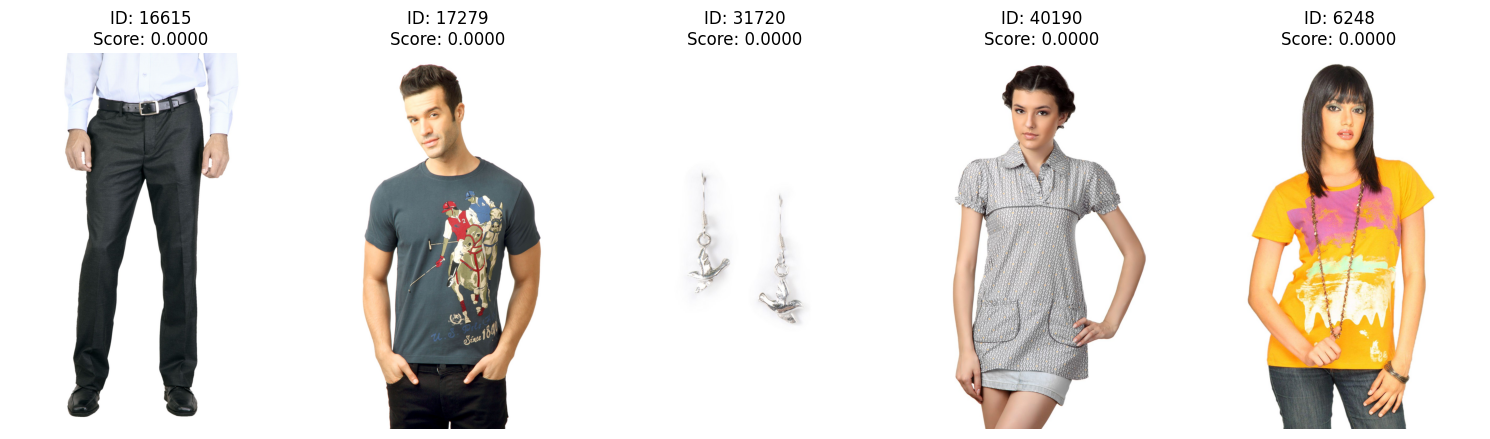

In [85]:
# to display recommended product images

import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

df2 = pd.read_csv('Final Fashion Dataset.csv')

def display_recommended_images(recommended_items, df):
    plt.figure(figsize=(15, 10))

    for i, (item_id, score) in enumerate(recommended_items):

        img_link = df.loc[df['id'] == item_id, 'link'].values[0]

        response = requests.get(img_link)
        img = Image.open(BytesIO(response.content))


        plt.subplot(1, len(recommended_items), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"ID: {item_id}\nScore: {score.item():.4f}")

    plt.tight_layout()
    plt.show()


display_recommended_images(recommended_items, df2)

In [90]:
df2[df2['user_id'] == 24592]

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,ratings,review,Month,Price (USD)
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,30757.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29
1405,24592,17186,Men,Apparel,Topwear,Shirts,Maroon,Winter,2016.0,Casual,U.S. Polo Assn. Men Checks Maroon Shirt,17186.jpg,http://assets.myntassets.com/v1/images/style/p...,1,"Cheap fabric, uncomfortable to wear. for speci...",May,21
4732,24592,53115,Men,Apparel,Topwear,Tshirts,Red,Summer,2012.0,Casual,Myntra Men Red Printed T-shirt,53115.jpg,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. for spe...,August,39
11077,24592,26494,Men,Apparel,Topwear,Tshirts,Green,Summer,2012.0,Casual,Puma Men Tyrel Green T-shirt,26494.jpg,http://assets.myntassets.com/v1/images/style/p...,3,"Good for casual wear, but not exceptional. and...",July,22
19396,24592,12928,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Classic Polo Men Rugby Kingdom Blue Tshirts,12928.jpg,http://assets.myntassets.com/v1/images/style/p...,5,"Exceeded expectations, love the fit! for speci...",August,55


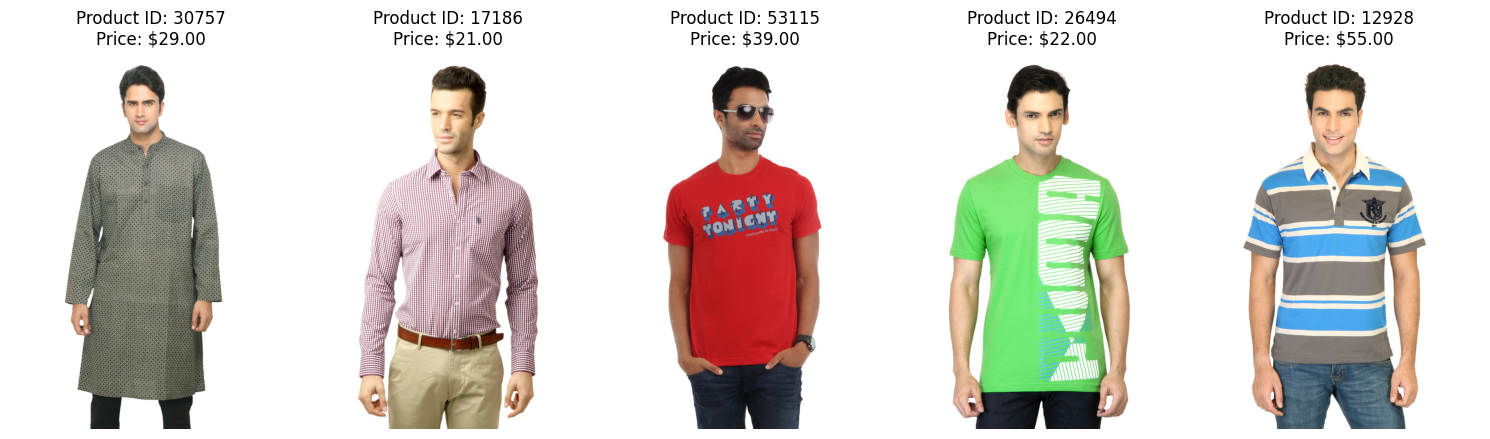

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib

user_id = 24592
user_products = df2[df2['user_id'] == user_id]


def display_user_images(user_products, max_images=1):

    user_products = user_products.head(max_images)


    plt.figure(figsize=(15, 5))


    for index, (i, row) in enumerate(user_products.iterrows(), 1):
        plt.subplot(1, max_images, index)
        image_url = row['link']
        try:

            image = mpimg.imread(urllib.request.urlopen(image_url), format='jpg')
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Product ID: {row['id']}\nPrice: ${row['Price (USD)']:.2f}")
        except Exception as e:
            print(f"Could not load image for Product ID {row['id']}: {e}")

    plt.tight_layout()
    plt.show()


display_user_images(user_products, max_images=5)